In [3]:
import os
import json

import time
import random
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.nn.functional as F

In [4]:
# 1. Original IPN Hand dataset (videos)
ipn_path = kagglehub.dataset_download("soumicksarker/ipn-hand-dataset")
print("IPN dataset:", ipn_path)

# --- Paths ---
videos_dir = os.path.join(ipn_path, "videos/videos")  # raw video files

annotations_path = os.path.join(ipn_path, "annotations/annotations")

def read_annotations(path):
    with open(path, 'r') as f:
        annots = []
        for idx, line in enumerate(f):
            if idx > 0:
                # Parse annotations and convert frame info into ints
                info = line.split(',')
                for i in range(2, len(info)):
                    info[i] = int(info[i])
                annots.append(info)
    return annots

annots = read_annotations(os.path.join(annotations_path, "Annot_List.txt"))


100%|██████████| 4.61G/4.61G [1:00:45<00:00, 1.36MB/s]

Extracting model files...


IPN dataset: C:\Users\billa\.cache\kagglehub\datasets\soumicksarker\ipn-hand-dataset\versions\7


In [5]:
# Use the same UNet() model from UNetScratchModel to extract segmentations

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Encoder
        for f in features:
            self.downs.append(self.conv_block(in_channels, f))
            in_channels = f

        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)

        # Decoder
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.ups.append(self.conv_block(f*2, f))

        # Final output
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final(x))

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )


In [32]:
class IPNRawFramesDataset(Dataset):
    """
    Dataset for UNet inference on IPN videos.
    
    Instead of returning a full 210-frame clip,
    this dataset returns *one frame* suitable for UNet:

        (3, H, W), label_id

    Default: selects the middle frame of the gesture clip.
    """

    def __init__(self, annots, videos_path, transform=None, resize=(256,256)):
        self.annots = annots
        self.videos_path = videos_path

        # transform for UNet input
        if transform is None:
            self.transform = T.Compose([
                T.ToTensor(),
                T.Resize((256,256))
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.annots)

    def _load_one_frame(self, video_name, frame_idx):
        """Load a single RGB frame as PIL."""
        video_path = os.path.join(self.videos_path, video_name + ".avi")

        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        if not cap.isOpened():
            raise FileNotFoundError(f"Video file not found: {video_path}")

        ret, frame = cap.read()
        cap.release()

        if not ret:
            raise RuntimeError(f"Failed to read frame {frame_idx} of {video_name}")

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return Image.fromarray(frame)

    def __getitem__(self, idx):
        """
        Annotation format:
        [video_name, label_string, label_id, start_frame, end_frame, num_frames]
        """

        video_name, _, label_id, start_frame, end_frame, _ = self.annots[idx]

        # Pick the middle frame of the gesture
        mid_frame = (start_frame + end_frame) // 2

        # Load frame
        frame = self._load_one_frame(video_name, mid_frame)

        # Preprocess for UNet
        frame_tensor = self.transform(frame)  # (3,H,W)

        return frame_tensor, label_id - 1


torch.Size([4, 1, 256, 256])
Click with two fingers


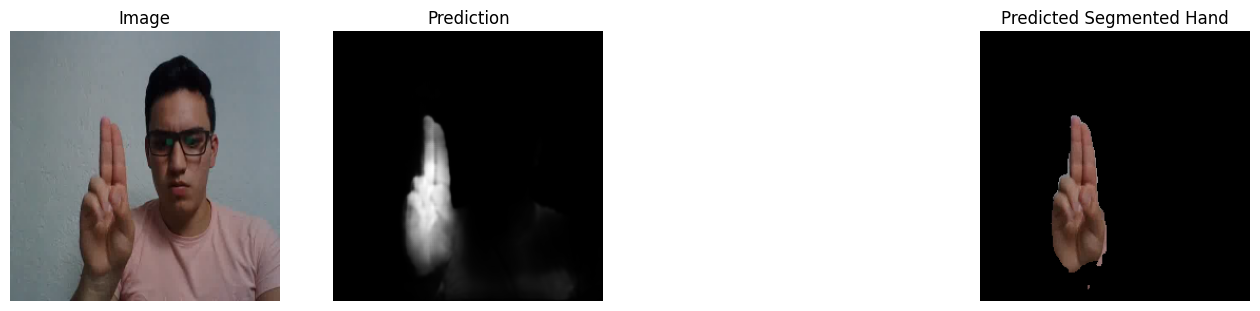

Pointing with two fingers


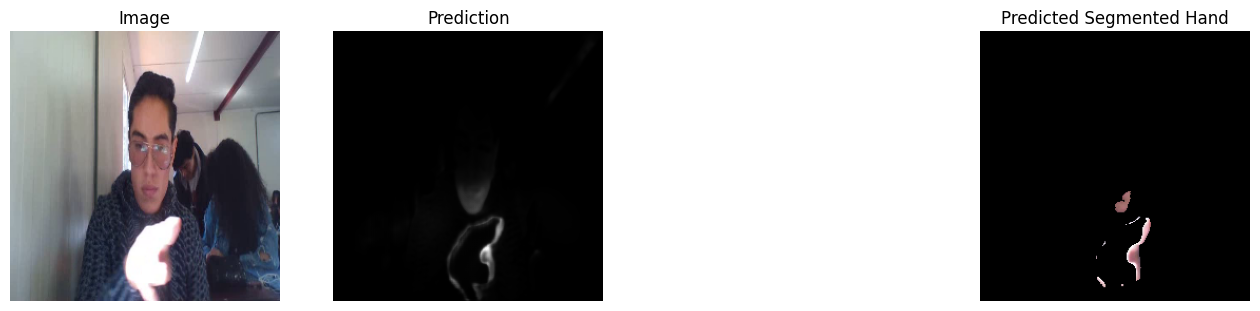

Open twice


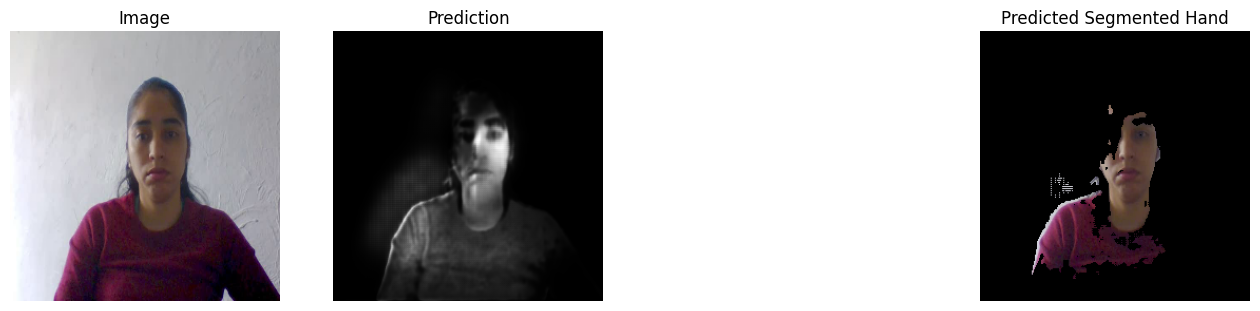

Non-gesture


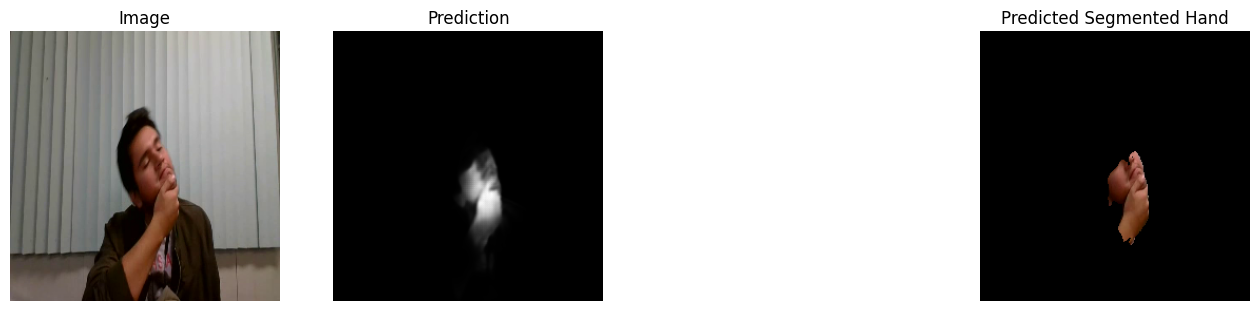

In [33]:

# Extract all segmentation masks

save_path = os.path.join("models", "hand_seg_model.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(save_path):
    raise FileNotFoundError(
        f"❌ The file {save_path} does NOT exist.\n"
        f"Set TRAIN_NEW_MODEL = True to train a new model first."
    )

model = UNet().to(device)
model.load_state_dict(torch.load(save_path, map_location=device))

dataset = IPNRawFramesDataset(
    annots,
    videos_path=videos_dir,
)


ID_TO_GESTURE = {
    0: "Non-gesture",
    1: "Pointing with one finger",
    2: "Pointing with two fingers",
    3: "Click with one finger",
    4: "Click with two fingers",
    5: "Throw up",
    6: "Throw down",
    7: "Throw left",
    8: "Throw right",
    9: "Open twice",
    10: "Double click with one finger",
    11: "Double click with two fingers",
    12: "Zoom in",
    13: "Zoom out",
}

loader = DataLoader(dataset, batch_size=4, shuffle=True)

model.eval()
with torch.no_grad():
    imgs, label = next(iter(loader))
    imgs, label = imgs.to(device), label.to(device)
    preds = model(imgs)

# preview label and image and mask
pred_shape = preds.shape
print(pred_shape)


for i in range(min(4, imgs.size(0))):
    print(ID_TO_GESTURE[label[i].item()])

    plt.figure(figsize=(16,4))


    # Original image
    plt.subplot(1,4,1)
    plt.imshow(imgs[i].cpu().permute(1,2,0))
    plt.title("Image")
    plt.axis("off")

    # Predicted mask
    pred_mask = preds[i,0].cpu()
    plt.subplot(1,4,2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    # Segmented predicted hand
    pred_mask_bin = (pred_mask > 0.1).float()   # threshold mask
    segmented = imgs[i].cpu() * pred_mask_bin   # apply mask
    segmented = segmented.permute(1,2,0)         # CHW → HWC

    plt.subplot(1,4,4)
    plt.imshow(segmented)
    plt.title("Predicted Segmented Hand")
    plt.axis("off")

    plt.show()


In [38]:
dataset_size = len(dataset)
sub_size = dataset_size // 5

# Optionally, fix random seed for reproducibility
torch.manual_seed(42)

# Randomly split dataset
# only use a small portion of the data to make training faster
subset, _ = random_split(dataset, [sub_size, dataset_size - sub_size])

val_fraction = 0.2  # 20% of data for validation
val_size = int(sub_size * val_fraction)
train_size = sub_size - val_size
train_dataset, val_dataset = random_split(subset, [train_size, val_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [39]:
input_dim = 256*256
num_classes = 14 # there are 14 gesture types

class BasicGLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 67),
            nn.ReLU(),
            nn.Linear(67, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        return self.net(x)

model = BasicGLP(input_dim, num_classes).to(device)
print(model)

BasicGLP(
  (net): Sequential(
    (0): Linear(in_features=65536, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=67, bias=True)
    (3): ReLU()
    (4): Linear(in_features=67, out_features=14, bias=True)
  )
)


In [40]:
seg_model = UNet().to(device)

save_path = os.path.join("models", "seg_gesture_rec_model.pth")


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# training loop

def run_epoch_seg_gest(loader, model, seg_model, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    correct = 0
    total = 0
    for img, label in loader:
        img = img.to(device, dtype=torch.float32)
        label = label.to(device)

        # print(label)

        if optimizer is not None:
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            pred = seg_model(img)

        logits = model(pred)           # forward pass
        loss = criterion(logits, label) # compute loss

        if optimizer is not None:
            loss.backward()               # backprop
            optimizer.step()              # update weights

        total_loss += loss.item() * img.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc

num_epochs = 25

train_accs = []
test_accs = []
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = run_epoch_seg_gest(train_loader, model, seg_model, criterion, optimizer)
    # test_loss, test_acc = run_epoch(test_loader, model, criterion, optimizer=None)
    train_accs.append(train_acc)
    # test_accs.append(test_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
        # f"test_loss={test_loss:.4f}, test_acc={test_acc:.3f}"
    )

tensor([ 1,  1,  7,  1,  2,  1,  1,  2,  4,  2,  5,  2,  1,  0,  0, 12,  0,  2,
         2,  1,  0,  5, 11,  7,  4,  4, 13,  0,  0, 12,  1,  2])
tensor([ 7, 10,  0,  2,  2,  2,  5,  0,  6,  0,  9,  0,  1,  0,  0,  2,  1,  1,
        13, 13,  6,  6,  6,  7,  0, 10,  2,  1, 12,  1,  3,  6])
tensor([ 6,  2,  2,  1,  1,  0, 11,  2,  1,  0,  9,  1,  9,  0,  0, 13,  2,  8,
         8,  0,  8,  1,  0,  0,  1,  9,  1,  2,  8,  1, 13, 11])
tensor([ 1, 12,  2, 13,  2, 13,  0,  0,  9,  1,  2,  4,  7,  1, 10,  0,  0,  1,
         1, 12, 11,  1,  0,  1,  3,  0,  1, 13,  3,  0,  0, 11])


KeyboardInterrupt: 

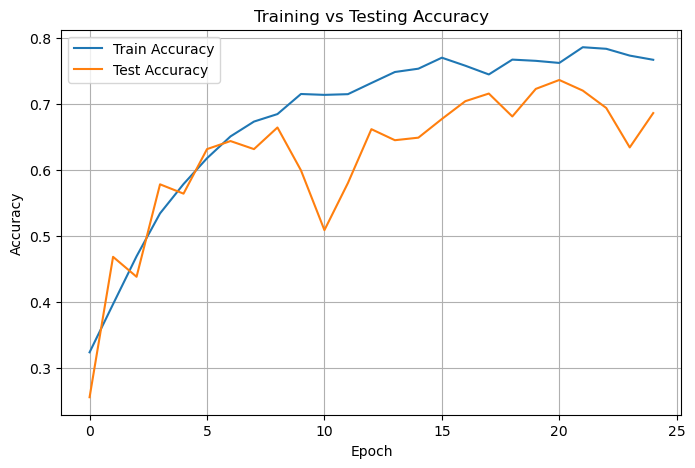

In [ ]:
epochs = np.arange(num_epochs)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()